In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats 
from scipy.stats import ttest_ind

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, plot_confusion_matrix,\
classification_report
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MinMaxScaler, MaxAbsScaler,\
QuantileTransformer, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

## Census Data Import and Cleaning 

In [3]:
census_df = pd.read_csv('data/NewYork.csv')
census_df.head()

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,EP_ASIAN,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE
0,36,New York,NY,36001,Albany,36001000100,"Census Tract 1, Albany County, New York",0.914079,2029,355,...,4.9,3.6,0.0,1.7,0.0,1.7,10.0,5.0,0.2,0.4
1,36,New York,NY,36001,Albany,36001000201,"Census Tract 2.01, Albany County, New York",0.237787,3263,759,...,2.7,3.2,0.0,1.1,0.0,1.1,6.2,4.8,0.0,1.1
2,36,New York,NY,36001,Albany,36001000202,"Census Tract 2.02, Albany County, New York",0.556562,2153,488,...,0.0,1.6,0.0,1.6,0.0,1.6,4.6,4.1,0.0,1.6
3,36,New York,NY,36001,Albany,36001000301,"Census Tract 3.01, Albany County, New York",0.254634,3016,602,...,13.0,8.5,0.0,1.2,0.0,1.2,3.9,5.5,0.0,1.2
4,36,New York,NY,36001,Albany,36001000302,"Census Tract 3.02, Albany County, New York",1.968324,2931,509,...,8.8,8.6,0.0,1.2,0.0,1.2,7.1,6.1,0.4,0.7


From reading through the data dictionary (included in the Data folder), I know that all columns beginning in M are thre margins of error for each population estimate. Additionally, I can drop all the percentile transformation columns and any unnecessary columns.

In [4]:
to_drop = ['M', 'EP', 'SP', 'F']

for col_name in census_df.columns:
    for string in to_drop:
        if col_name.startswith(string):
            census_df.drop(columns=col_name, inplace=True)
            break

census_df.drop(columns = ['RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'E_DAYPOP',
                          'E_AFAM', 'E_HISP', 'E_ASIAN', 'E_AIAN', 'E_NHPI','E_TWOMORE', 
                          'E_OTHERRACE'], inplace = True)
census_df.drop(columns = ['ST', 'STATE', 'ST_ABBR', 'STCNTY', 'LOCATION'], inplace = True)
census_df.rename({'RPL_THEMES': 'SVI_Rank'}, inplace = True, axis =1)

Additional Notes From Data Dictionary

* Tracts with zero estimates for total population (N = 645 for the U.S.) were removed during the ranking process. These tracts were added back to the SVI databases after ranking. The TOTPOP field value is 0, but the percentile ranking fields (RPL_THEME1, RPL_THEME2, RPL_THEME3, RPL_THEME4, and RPL_THEMES) were set to -999.

* For tracts with > 0 TOTPOP, a value of -999 in any field either means the value was unavailable from the original census data or we could not calculate a derived value because of unavailable census data.

* Any cells with a -999 were not used for further calculations.

I'll remove any rows with SVI Rank of -999 since they contain no data. Values of 999 in rows containing data will be imputed later on after the Train-Test split 

In [5]:
missing_SVI = census_df.loc[census_df['SVI_Rank'] == -999]
census_df = census_df.drop(index = missing_SVI.index).reset_index(drop = True)

## COVID Data Import and Cleaning 

In [6]:
covid_df = pd.read_csv('data/United_States_COVID-19_Community_Levels_by_County.csv')

#Data is limited to New York to align with the census data
#Census data is dated 2020, so I used the earliest update in the COVID data

ny_covid_df = covid_df[covid_df['state'] == 'New York']
ny_covid_df = ny_covid_df[ny_covid_df['date_updated'] == '2022-02-24' ]

Text(0.5, 1.0, 'COVID-19 Cases by COVID-19 Community Level')

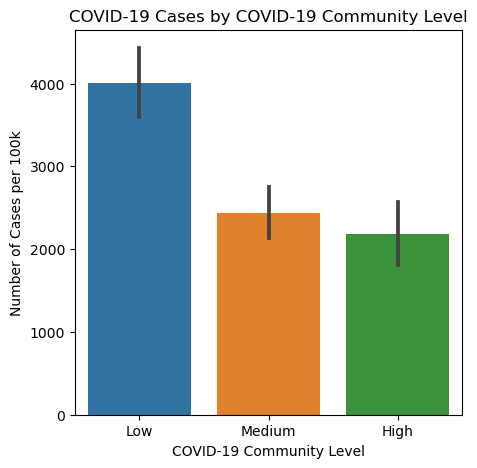

In [7]:
fig, ax = plt.subplots(figsize = (5,5))
sns.barplot(x = 'covid-19_community_level', y = 'covid_cases_per_100k', data = ny_covid_df,
            estimator = np.sum, order = ['Low', 'Medium', 'High'])
ax.set_xlabel('COVID-19 Community Level')
ax.set_ylabel('Number of Cases per 100k')
ax.set_title('COVID-19 Cases by COVID-19 Community Level')

In [8]:
#Preparing data to be merged with census_df

ny_county_covid = ny_covid_df[['county', 'covid-19_community_level']]
ny_county_covid['county'] = ny_county_covid['county'].str.split().str[0]
ny_county_covid['county'].replace(['New', 'St.'], ['New York', 'St. Lawrence'], inplace = True)
ny_county_covid.rename(columns = {'county': 'COUNTY'}, inplace = True)

/var/folders/bz/wt88kdhn16b5hb19ht43l3pw0000gn/T/ipykernel_89316/1303389442.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ny_county_covid['county'] = ny_county_covid['county'].str.split().str[0]
/var/folders/bz/wt88kdhn16b5hb19ht43l3pw0000gn/T/ipykernel_89316/1303389442.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ny_county_covid['county'].replace(['New', 'St.'], ['New York', 'St. Lawrence'], inplace = True)
/var/folders/bz/wt88kdhn16b5hb19ht43l3pw0000gn/T/ipykernel_89316/1303389442.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy

## EDA

In [9]:
#Merging census_df and ny_county_covid to create final dataframe for analysis 

joint_df = census_df.merge(ny_county_covid, how = 'left', on = 'COUNTY')
joint_df = joint_df.rename(columns = {'covid-19_community_level': 'target'})
joint_df = joint_df.drop(columns = ['SVI_Rank', 'COUNTY'])

Referring back to the data dictionary, I know I need to mark the missing values for imputation later on. I will also encode my target into a numeric value. 

In [10]:
joint_df.replace(999, np.nan, inplace = True )
joint_df['target'] = joint_df['target'].map({'Low':0, 'Medium': 1, 'High': 2})
joint_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5260 entries, 0 to 5259
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AREA_SQMI  5260 non-null   float64
 1   E_TOTPOP   5260 non-null   int64  
 2   E_HU       5259 non-null   float64
 3   E_HH       5258 non-null   float64
 4   E_POV150   5258 non-null   float64
 5   E_UNEMP    5260 non-null   int64  
 6   E_HBURD    5260 non-null   int64  
 7   E_NOHSDP   5259 non-null   float64
 8   E_UNINSUR  5260 non-null   int64  
 9   E_AGE65    5258 non-null   float64
 10  E_AGE17    5258 non-null   float64
 11  E_DISABL   5260 non-null   int64  
 12  E_SNGPNT   5260 non-null   int64  
 13  E_LIMENG   5259 non-null   float64
 14  E_MINRTY   5258 non-null   float64
 15  E_MUNIT    5258 non-null   float64
 16  E_MOBILE   5260 non-null   int64  
 17  E_CROWD    5260 non-null   int64  
 18  E_NOVEH    5258 non-null   float64
 19  E_GROUPQ   5260 non-null   int64  
 20  E_NOINT 

Begin EDA by visualizing the relationship between the independent variables

KeyboardInterrupt: 

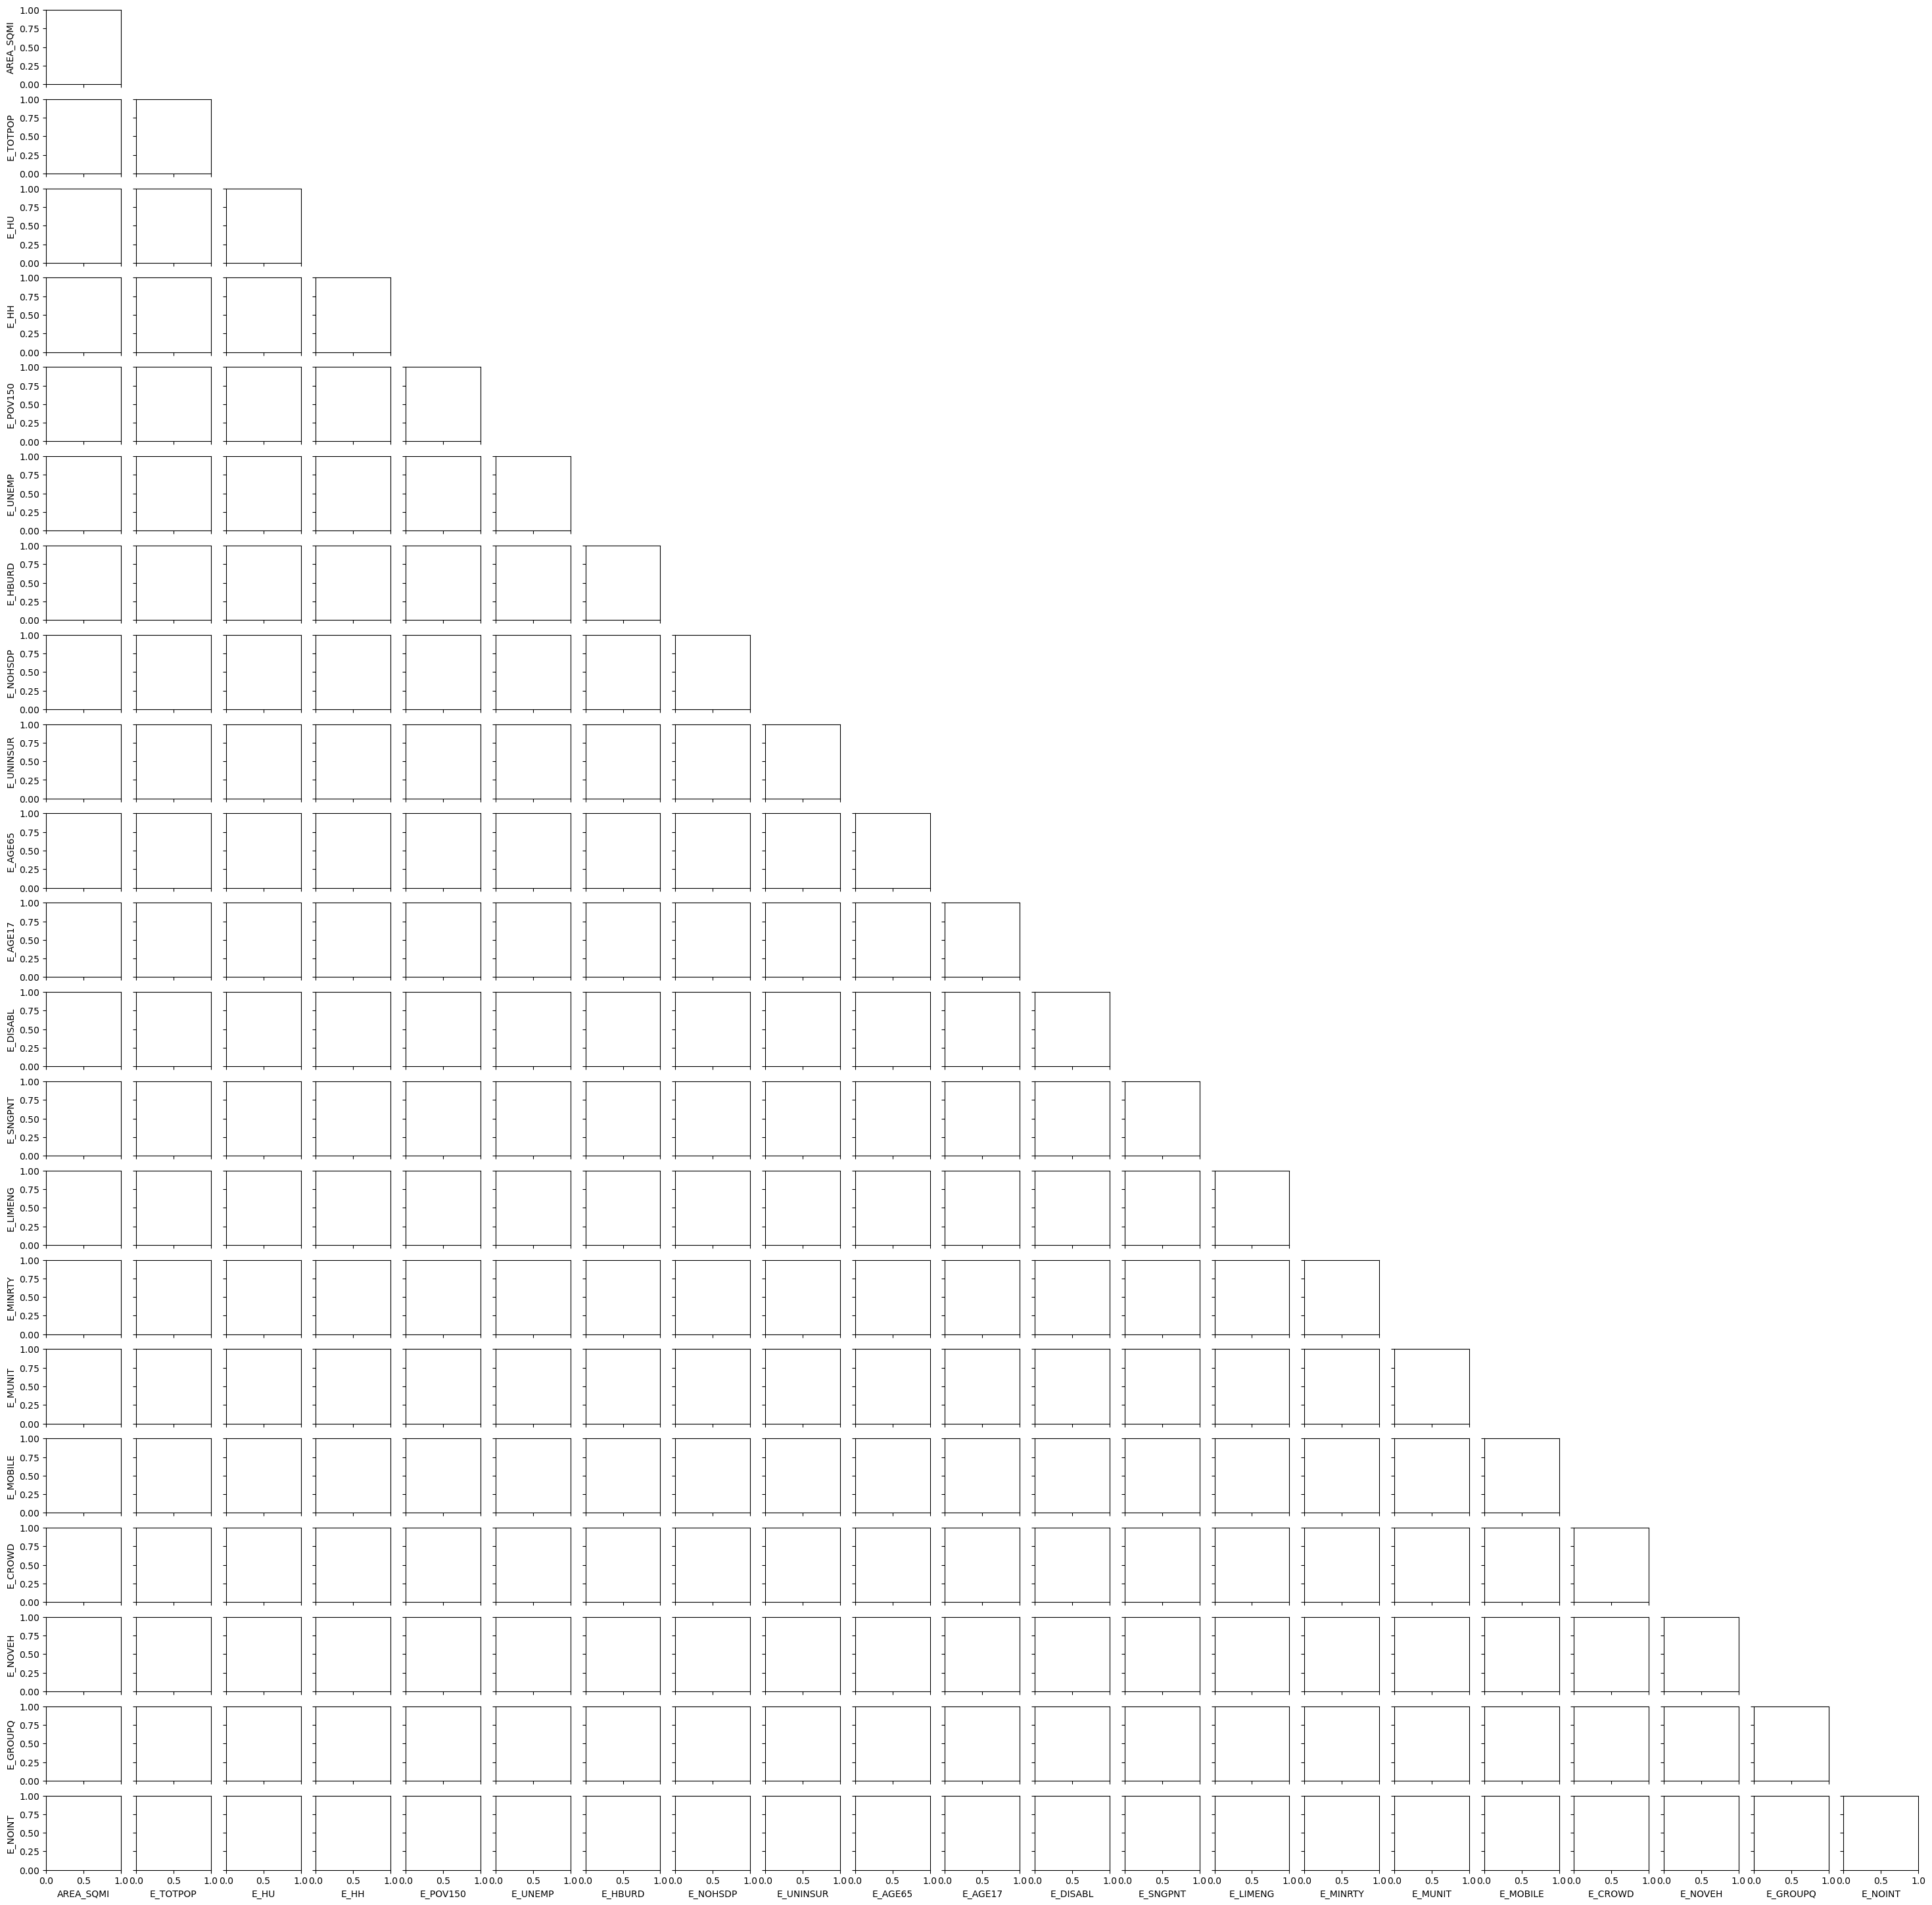

In [11]:
sns.pairplot(hue = 'target', data = joint_df, height = 1.75, corner = True)

Many of the variables are colinear, which makes sense becuase they are all population estimates. Use of regularization techniques will be important. I also notice that the most of the variables are not normally distributed 

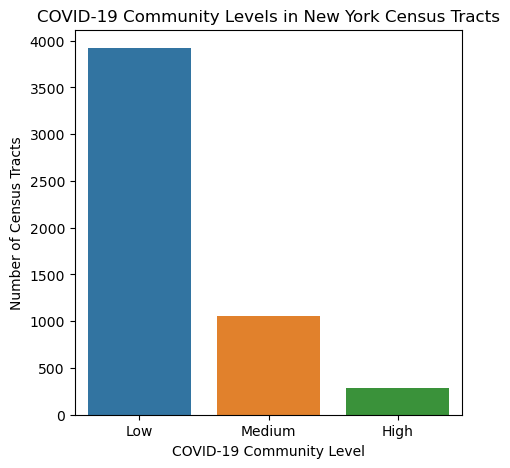

In [12]:
fig, ax = plt.subplots(figsize = (5,5))
sns.countplot(x = 'target', data = joint_df)
ax.set_xticklabels(['Low', 'Medium', 'High'])
ax.set_xlabel('COVID-19 Community Level')
ax.set_ylabel('Number of Census Tracts')
ax.set_title('COVID-19 Community Levels in New York Census Tracts')
plt.show()

The target is very imbalanced. Use of an oversampling technique will be necessary to train the model to predict the minority class 

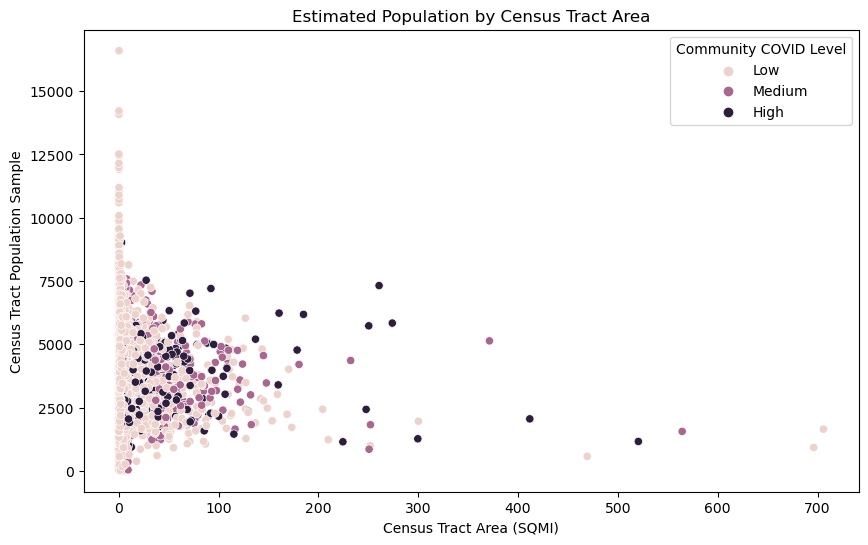

In [18]:
fig, ax = plt.subplots(figsize = (10,6))
sns.scatterplot(x = 'AREA_SQMI', y = 'E_TOTPOP', hue = 'target', data = joint_df, legend = 'brief')
ax.set_xlabel('Census Tract Area (SQMI)')
ax.set_ylabel('Census Tract Population Sample')
handles, labels = ax.get_legend_handles_labels()
label_dict = {0: 'Low', 1: 'Medium', 2: 'High'}
new_labels = [label_dict.get(int(label), label) for label in labels]
ax.legend(handles=handles, labels=new_labels, title='Community COVID Level')
ax.set_title('Estimated Population by Census Tract Area');

New York is densely populated. The majority of the population lives in census tracts that are very small. Given what we know about the spread of COVID, my hypothesis is that both of these factors will be influential in predicting community COVID levels.

## Train - Test Split

In [19]:
X = joint_df.drop(columns = 'target')
y = joint_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = .25, random_state = 42) 

## Baseline Model

In this model and all subsequent model, we will be setting up pipelines to streamline the model building process 

In [20]:
steps = [('imputer', SimpleImputer(strategy="median")), ('std_scaler', StandardScaler()),
        ('lr', LogisticRegression(solver = 'saga', random_state=42))]

baseline_pipe = Pipeline(steps)
baseline_pipe

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('std_scaler', StandardScaler()),
                ('lr', LogisticRegression(random_state=42, solver='saga'))])

In [21]:
#create custom cross validation function for future use 

def cross_validation(X_train, y_train, estimator, num_split = 5):
    
    X_train = X_train.values
    y_train = y_train.values
    
    score_train_list = []
    score_val_list = []
    
    for train_index, valid_index in KFold(n_splits = num_split).split(X_train):
        
        # train and validation splitting 
        X_train_fold, X_val_fold = X_train[train_index], X_train[valid_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[valid_index]

        estimator.fit(X_train_fold, y_train_fold)
        
        # now how did we do?
        accuracy_train = estimator.score(X_train_fold, y_train_fold)
        accuracy_val = estimator.score(X_val_fold, y_val_fold)
        score_val_list.append(accuracy_val)
        score_train_list.append(accuracy_train)
    
    return {'train': np.mean(score_train_list), 'validation': np.mean(score_val_list)}

/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'train': 0.827122940430925, 'validation': 0.8243346007604563}
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       980
           1       0.66      0.59      0.62       264
           2       0.38      0.11      0.17        71

    accuracy                           0.82      1315
   macro avg       0.64      0.55      0.57      1315
weighted avg       0.80      0.82      0.81      1315



/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


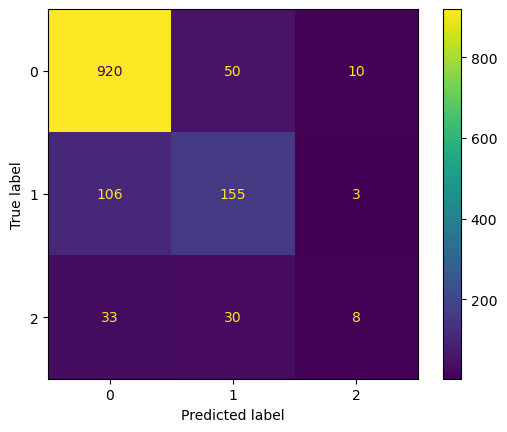

In [23]:
#Assess baseline model performance

print(cross_validation(X_train, y_train, baseline_pipe))
plot_confusion_matrix(baseline_pipe, X_test, y_test)
y_pred = baseline_pipe.predict(X_test)
print(classification_report(y_test, y_pred))

Baseline model is 82.4% accurate, but misses almost all of the high covid level census tracts. Given the business problem, it is better to accurately classify more high risk areas, even if there are more false positives. In future models, I will give larger consideration to class 2 recall as a metric of success 

## Model 2: Logistic Regression with Oversampling

In [27]:
steps_2 = [('imputer', SimpleImputer(strategy="median")),
           ('sampler', SMOTE(sampling_strategy = 'minority', random_state =42)),
           ('std_scaler', StandardScaler()),
        ('lr', LogisticRegression(solver = 'saga', random_state=42))]

sm_pipe = Pipeline(steps_2)
sm_model = sm_pipe.fit(X_train, y_train)

/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'train': 0.7520912547528515, 'validation': 0.7477820025348543}
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       980
           1       0.84      0.25      0.38       264
           2       0.19      0.89      0.32        71

    accuracy                           0.75      1315
   macro avg       0.66      0.67      0.53      1315
weighted avg       0.88      0.75      0.77      1315



/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


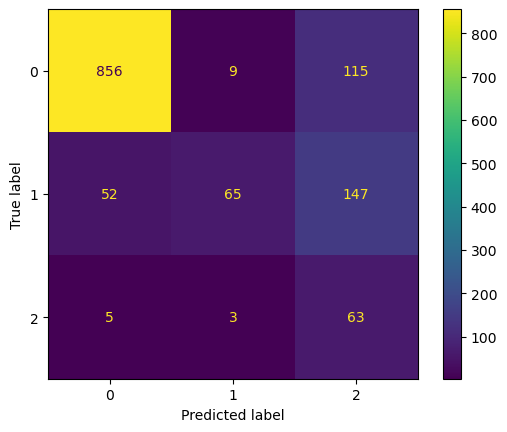

In [28]:
#assess model performance 
print(cross_validation(X_train, y_train, sm_pipe))
plot_confusion_matrix(sm_model, X_test, y_test)
y_pred = sm_model.predict(X_test)
print(classification_report(y_test, y_pred))

Overall accuracy drops to 75%, but class 2 recall is up to 89%. I will now consider this my best model.

## Model 3: Tuned Logistic Regression with Oversampling 

In [30]:
c_values = [10 ** i for i in range(-3, 4)]
tol_values = [1, 1e-1, 1e-2, 1e-3, 1e-4]
max_iter_values = np.arange(500, 20000, 500)

params = {'lr__penalty': ['l1', 'l2'],
          'lr__C': c_values,
         'lr__max_iter': max_iter_values,
         'lr__tol': tol_values}

cv = GridSearchCV(estimator = sm_model, param_grid = params, cv = 5, n_jobs = -1)
cv.fit(X_train, y_train)
best_sm_model = cv.best_estimator_

/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/s

In [ ]:
print(cross_validation(X_train, y_train, best_sm_model))
plot_confusion_matrix(best_sm_model, X_test, y_test)
y_pred = best_sm_model.predict(X_test)
print(classification_report(y_test, y_pred))

The tuned model is slightly more accurate than the original oversampled logistic regression, but lacks the high recall value for class 2. I will stick with model 2 as my best model for now. 

## Model 4: Decision Tree

In [ ]:
steps_4 = [('imputer', SimpleImputer(strategy="median")),
        ('sampler', SMOTE(sampling_strategy = 'minority', random_state =42)),   
        ('dt', DecisionTreeClassifier(max_depth = 10, random_state = 42))]

dt_pipe = Pipeline(steps_4)
dt_model = dt_pipe.fit(X_train, y_train)

In [ ]:
#assess model performance

print(cross_validation(X_train, y_train, dt_model))
plot_confusion_matrix(dt_model, X_test, y_test)
y_pred = dt_model.predict(X_test)
print(classification_report(y_test, y_pred))

Decision Tree produces a high training score, but also a high amount of variance. I can tell the model is overfitting by comparing the train and validation scores. I will attempt to tune the model to reduce the overfitting.

## Model 5: Tuned Decision Tree

In [ ]:
max_depth_values = range(2,11)
min_sample_leaf_values = range(2,6)
max_feature_values = range(2,22)
criterion_values = ['gini', 'entropy']
splitter_values = ['best', 'random']
class_weight_values = ['balanced', None]

params = {'dt__max_depth': max_depth_values,
           'dt__min_samples_leaf': min_sample_leaf_values,
          'dt__max_features': max_feature_values,
          'dt__criterion': criterion_values,
         'dt__splitter': splitter_values,
         'dt__class_weight': class_weight_values}

dt_cv = GridSearchCV(estimator = dt_model, param_grid = params, cv = 5, n_jobs = -1)
dt_cv.fit(X_train, y_train)
best_dt_model = dt_cv.best_estimator_

In [ ]:
#assess model performance

print(cross_validation(X_train, y_train, best_sm_model))
plot_confusion_matrix(best_sm_model, X_test, y_test)
y_pred = best_sm_model.predict(X_test)
print(classification_report(y_test, y_pred))

There is a small reduction in the overfitting, but the accuracy and class 2 recall is still lower than my best model, so I will keep going.

## Model 6: Random Forest

In [31]:
rf_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('sampler', SMOTE(sampling_strategy = 'minority', random_state =42)),
    ('std_scaler', StandardScaler()),
    ('rf', RandomForestClassifier(n_estimators=150, random_state = 42))])

rf_model = rf_pipe.fit(X_train, y_train)


{'train': 1.0, 'validation': 0.7782002534854247}
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       980
           1       0.71      0.38      0.49       264
           2       0.25      0.61      0.36        71

    accuracy                           0.78      1315
   macro avg       0.61      0.63      0.58      1315
weighted avg       0.81      0.78      0.78      1315



/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


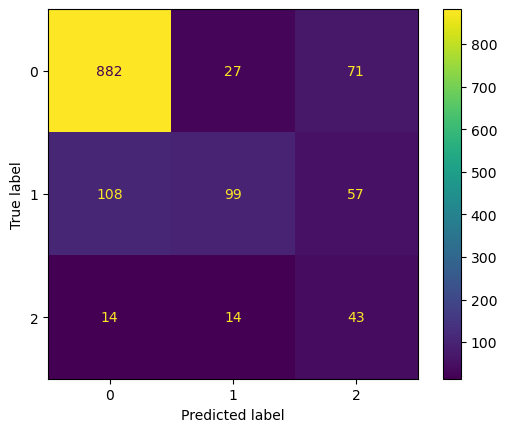

In [32]:
print(cross_validation(X_train, y_train, rf_model))
plot_confusion_matrix(rf_model, X_test, y_test)
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

There is improvement in the overall accuracy, but the model is extremely overfitted. I will try to tune it to improve accuracy score while also managing features to reduce overfitting.

## Model 7: Tuned Random Forest

In [ ]:
params = {'rf__n_estimators': [10, 50, 100, 200, 500],
          'rf__max_depth': [5, 10, 20, None],
          'rf__min_samples_split': [2, 5, 10],
          'rf__min_samples_leaf': [1, 2, 4],
          'rf__max_features': ['auto', 'sqrt', 'log2', None]}

rf_cv = GridSearchCV(estimator = rf_model, param_grid = params, cv = 5, n_jobs = -1)
rf_cv.fit(X_train, y_train)
best_rf_model = rf_cv.best_estimator_

In [ ]:
#play around with the max depth to reduce overfitting while maximizing accuracy and class 2 recall

# best_rf_model.set_params(rf__max_depth = 10)
# best_rf_model.set_params(rf__max_depth = 5)
best_rf_model.set_params(rf__max_depth = 6)
# best_rf_model.set_params(rf__max_depth = 7)

In [ ]:
#Assess model performance 

print(cross_validation(X_train, y_train, best_rf_model))
plot_confusion_matrix(best_rf_model, X_test, y_test)
y_pred = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

Random forest is capable of achieving a higher accuracy than the logistic regression model, but is prone to overfitting. By adjusting the max depth, I was able to reduce the overfitting, but the best scores were 73% accuracy and 63% class 2 recall. My current best model is still superior. 

## Model 8: Gradient Boost 

In [33]:
gb_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('sampler', SMOTE(sampling_strategy = 'minority', random_state =42)),
    ('std_scaler', StandardScaler()),
    ('gb', XGBClassifier(random_state = 42))])

gb_model = gb_pipe.fit(X_train, y_train)

{'train': 1.0, 'validation': 0.802281368821293}
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       980
           1       0.65      0.45      0.53       264
           2       0.26      0.55      0.36        71

    accuracy                           0.79      1315
   macro avg       0.60      0.63      0.59      1315
weighted avg       0.81      0.79      0.79      1315



/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


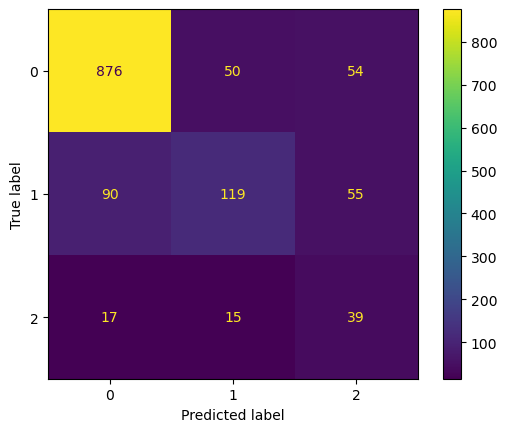

In [34]:
print(cross_validation(X_train, y_train, gb_model))
plot_confusion_matrix(gb_model, X_test, y_test)
y_pred = gb_model.predict(X_test)
print(classification_report(y_test, y_pred))

Similar to the random forest, the validation accuracy score was high, but the model is overfitting. I will attempt to tune it to increase accuracy and reduce variance.

## Model 9: Tuned Gradient Boost

In [ ]:
params = {'gb__n_estimators': [50, 100, 200, 300, 400, 500],
          'gb__max_depth': [1, 2, 3, 4, 5],
          'gb__learning_rate': [.01, .03, .05, .07, .1],
          'gb__subsample': [0.5, 0.75, 1]}

gb_cv = GridSearchCV(estimator = gb_model, param_grid = params, cv = 5, n_jobs = -1)
gb_cv.fit(X_train, y_train)
best_gb_model = gb_cv.best_estimator_

In [ ]:
#Assess model

print(cross_validation(X_train, y_train, best_gb_model))
plot_confusion_matrix(best_gb_model, X_test, y_test)
y_pred = best_gb_model.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
#Try to reduce overfitting

best_gb_model_overfit = best_gb_model.set_params(gb__max_depth = 5)
best_gb_model_overfit.fit(X_train, y_train)

In [ ]:
#Assess model

print(cross_validation(X_train, y_train, best_gb_model_overfit))
plot_confusion_matrix(best_gb_model_overfit, X_test, y_test)
y_pred = best_gb_model_overfit.predict(X_test)
print(classification_report(y_test, y_pred))

Tuned model is still very overfitted. I was able to reduce the overfitting by reducing the max depth and decreasing the learning rate, but ultimately the accuracy was only a couple points better than my current best model, but with a 40% lower class 2 recall. I will continue to use the oversampled logistic regression as my best model.

In [ ]:
feat_imp = pd.Series(best_gb_model_overfit.named_steps['gb'].feature_importances_,
             index = X_train.columns).sort_values(ascending = False)

top_5 = feat_imp.head()
fig, ax = plt.subplots()
sns.barplot(x = top_5.index, y = top_5.values)
ax.set_xlabel('Features')
ax.set_ylabel('Feature Importance')
ax.set_title('Top 5 Most Important Features')
new_labels = ['Area', 'Mobile Homes', 'Poverty','Low English', 'Crowded Home']
ax.set_xticklabels(new_labels);


This visual tells us which features are the most influential in determining community COVID level and will be part of recommendation to the stakeholder.

## Model 10: K-Nearest Neighbor

In [ ]:
knn_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('sampler', SMOTE(sampling_strategy = 'minority', random_state =42)),
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_jobs = -1) )])

knn_model = knn_pipe.fit(X_train, y_train)

In [ ]:
print(cross_validation(X_train, y_train, knn_model))
plot_confusion_matrix(knn_model, X_test, y_test)
y_pred = knn_model.predict(X_test)
print(classification_report(y_test, y_pred))

Similar to XGB Classifier, KNN produces improved accuracy scores, but is overfitted and has lower class 2 recall. I will attempt to tune this model as well.

## Model 11: Tuned K-Nearest Neighbor

In [ ]:
params = {'knn__weights': ['uniform', 'distance'],
          'knn__n_neighbors': range(5, 21),
          'knn__leaf_size': [5, 10, 20, 30, 40, 50]}

knn_cv = GridSearchCV(estimator = knn_model, param_grid = params, cv = 5, n_jobs = -1)
knn_cv.fit(X_train, y_train)
best_knn_model = knn_cv.best_estimator_

In [ ]:
print(cross_validation(X_train, y_train, best_knn_model))
plot_confusion_matrix(best_knn_model, X_test, y_test)
y_pred = best_knn_model.predict(X_test)
print(classification_report(y_test, y_pred))

Model continue to overfit and scores are not an improvement over the reigning best model.

## Model 12: Stacked XGB Classifier and Logistic Regression 

I will choose my two best models to stack together. The first model will be my current best model, the oversampled logistic regression. The second model will be the tuned gradient boost with the overfitting reduced.

In [ ]:
estimators = [('lr', sm_model),
             ('gb', best_gb_model_overfit)]

sc = StackingClassifier(estimators)
lr_gb_model = sc.fit(X_train, y_train)


In [ ]:
#Assess model performance 
print(cross_validation(X_train, y_train, lr_gb_model))
plot_confusion_matrix(lr_gb_model, X_test, y_test)
y_pred = lr_gb_model.predict(X_test)
print(classification_report(y_test, y_pred))

One of the highest accuracy scores, but the model is still overfitting and the class 2 recall is very low at 23%. I will use the oversampled logistic regression as my final model and use it to see if I can find any insights for my stakeholder 

## Experimenting with Dropping some Features

I will use my feature importance from the XGB Classifier to find the least important features and drop them from my best model.

In [ ]:
feat_imp
joint_df_2 = joint_df.drop(columns = ['E_HBURD', 'E_UNEMP', 'E_TOTPOP', 'E_DISABL', 'E_AGE17'])

X_2 = joint_df_2.drop(columns = 'target')
y_2 = joint_df_2['target']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, stratify = y, test_size = .25, random_state = 42) 

In [ ]:
#Assess model performance
sm_model.fit(X_train_2, y_train_2)
print(cross_validation(X_train_2, y_train_2, sm_model))
plot_confusion_matrix(sm_model, X_test_2, y_test_2)
y_pred = sm_model.predict(X_test_2)
print(classification_report(y_test_2, y_pred))

Resulting model was not improved in any of the key criteria so I will leave all features in.  

## Drawing Insights from Predictions 

In [ ]:
preds = sm_model.predict(X_test)
preds_df = pd.concat([X_test.reset_index(), pd.Series(preds)],1)
preds_df['preds'] = preds

low = preds_df.loc[preds_df['preds'] == 0]
medium = preds_df.loc[preds_df['preds'] == 1]
high = preds_df.loc[preds_df['preds'] == 2]

fig, ax  = plt.subplots(figsize = (10,6))
sns.distplot(low['E_POV150'], label = 'Low')
sns.distplot(medium['E_POV150'], label = 'Medium')
sns.distplot(high['E_POV150'], label = 'High')
ax.set_xlabel('Estimated Population Living 150% Below Poverty Level')
ax.set_title('Distribution of Estimated Population Living 150% Below Poverty Level')
ax.legend(title = "Predicted Community COVID Level")
fig.show()

In [ ]:
result = stats.f_oneway(low['E_POV150'], medium['E_POV150'], high['E_POV150']) 
f_stat, p = result

if p < .05:
    print('The mean populations living in poverty for each COVID Level group are meaningfully different at the 95% confidence level')
else:
    print('The mean populations living in poverty for each COVID Level group are not meaningfully different')

In [ ]:
t_stat1, p_value1 = stats.ttest_ind(low['E_POV150'], medium['E_POV150'], equal_var = False)
t_stat2, p_value2 = stats.ttest_ind(low['E_POV150'], high['E_POV150'], equal_var = False)

if p_value1 and p_value2 < .05:
    print('The mean populations living in poverty for each COVID Level group are meaningfully different at the 95% confidence level')
else:
    print('The mean populations living in poverty for each COVID Level group are not meaningfully different')

Using the model, I created predictions for community COVID levels for the test data sample. The distribution of the population living 150% below the poverty rate for the 3 groups showed that predicted high COVID level areas had a higher mean poverty population. Using statistical methods ANOVA and T-tests, I compared the means at the 95% confidence level and found that they are meanigfully different. Monitoring local poverty rates as an indicator of vulnerable populations will be part of my recommendation to the stakeholders. 

In [ ]:
fig, ax  = plt.subplots(figsize = (10,6))
sns.boxplot(x = 'preds', y = 'E_MOBILE', data = preds_df, labels = ['Low', 'Medium'])
ax.set_xlabel('Estimated Population Living 150% Below Poverty Level')
ax.set_title('Distribution of Estimated Population Living 150% Below Poverty Level')
ax.legend(title = "Predicted Community COVID Level")
ax.set_xticklabels(['Low', 'Medium', 'Hihg'])
fig.show()

The population living in mobile homes was a feature that was surprisingly influential in classifying community COVID levels. Looking at the distribution of mobile homes by predicted COVID levels, I can see a clear distinction between High COVID areas and the other two classes. Monitoring the local mobile home population as an indicator of vulnerable populations will be the second part of my recommendation to the stakeholders.